### Due to increasing rate of travel of agents, the confidence intervals are much more narrow (In former case with very low travel rate, we had simulations of about 200 people per district. Now that we have high travel rate, each group of 200 people per district is far more connected (inter-district travel, meaning that we are modeling more as a country, still keeping influences by district instead), meaning that with the larger country population size, it much harder for disease to die out, and overall, much more similar results occur across each run, as variation between results decreases with increased sample size (modeling more as country of 100,000 people and less of districts with about 200 people per).) 

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from textwrap import wrap
import random
from functools import reduce
import pickle
import dabest
from random import choices
import matplotlib.ticker as mtick
from scipy.stats import bootstrap
from statistics import stdev
import scipy
from matplotlib.colors import LogNorm

In [3]:
def percentile_confidence_interval(data):    
    return(np.percentile(data, 2.5),np.percentile(data, 97.5),np.percentile(data, 50))

In [4]:
with open("gamma_latest_3_22_current_data/incrementing_vaccinations_current_all_data.pkl",'rb') as handle:
    medians_current=pickle.load(handle)

In [5]:
for index,i in enumerate(medians_current[11]):
    print(index,':',i[len(i)-1])

0 : 151356.5
1 : 150425.0
2 : 147534.5
3 : 144059.0
4 : 126413.0


In [6]:
with open("gamma_latest_3_22_current_data/current_vaccination_curves_returned.pkl",'rb') as handle:
    current_vaccination_curves=pickle.load(handle)


with open("gamma_latest_3_22_current_data/no_vaccination_curves_returned.pkl",'rb') as handle:
    no_vaccination_curves=pickle.load(handle)
    

In [7]:
geo_df = gpd.read_file('India_State_Shapefile/India_State_Boundary.shp')

In [8]:
ABM_states=["andaman & nicobar islands", "dadra & nagar haveli and daman & diu", "chhattisgarh", "haryana", "manipur", "assam", "meghalaya", "gujarat", "kerala", "goa", "jammu & kashmir", "nagaland", "mizoram", "tamil nadu", "west bengal", "maharashtra", "andhra pradesh", "tripura", "chandigarh", "punjab", "himachal pradesh", "telangana", "rajasthan", "uttarakhand", "sikkim", "jharkhand", "uttar pradesh", "lakshadweep", "puducherry", "bihar", "madhya pradesh", "arunachal pradesh", "ladakh", "delhi", "odisha", "karnataka"]

In [9]:
dict_states_replace=dict()

dict_states_replace['andaman & nicobar']='andaman & nicobar islands'
dict_states_replace['daman and diu and dadra and nagar haveli']='dadra & nagar haveli and daman & diu'
dict_states_replace['tamilnadu']='tamil nadu'
dict_states_replace['chhattishgarh']='chhattisgarh'
dict_states_replace['telengana']='telangana'
dict_states_replace['jammu and kashmir']='jammu & kashmir'

In [10]:
names_replaced=[]

for name in geo_df['Name']:
    try:
        names_replaced+=[dict_states_replace[name.lower()]]
    except:
        names_replaced+=[name.lower()]
        
geo_df['Name']=names_replaced #Adusted state names so that they are consistent between the geopandas DataFrame and
                                #the naming in the ABM (so that DataFrames can be merged at the state level)

### Cases per child per year

total cases steady state divided by mean children alive in that period, divided by 2 (2 years)

In [11]:
#compiled_df.sort_values(['Difference in cases per child per year'],ascending=False)

In [12]:
last_10=dict()
last_10_novax=dict()
difference_median_vaccinated=dict()
difference_median_vaccinated_CIs=dict()
for state in geo_df['Name'].values:
    current_state_incidence=[]
    for i in range(len(current_vaccination_curves)):
        try:
            total_alive_current=sum([np.array(current_vaccination_curves[i][11][i])-np.array(current_vaccination_curves[i][16][i])-np.array(current_vaccination_curves[i][28][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
            
            incidence=current_vaccination_curves[i][18][state]/(np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])*(current_vaccination_curves[i][4][state]/sum(current_vaccination_curves[i][4].values())))/2
            #if prev>0:
            current_state_incidence+=[1000*incidence]
        except:
            pass
    
    last_10[state]=np.median(current_state_incidence)
    
    no_vacc_incidence=[]

    for i in range(len(no_vaccination_curves)):
        try:
            total_alive_no_vacc=sum([np.array(no_vaccination_curves[i][11][i])-np.array(no_vaccination_curves[i][16][i])-np.array(no_vaccination_curves[i][27][i]) for i in range(5)])            
            incidence=no_vaccination_curves[i][18][state]/(np.mean(total_alive_no_vacc[len(total_alive_no_vacc)-365*2:len(total_alive_no_vacc)])*(no_vaccination_curves[i][4][state]/sum(no_vaccination_curves[i][4].values())))/2
            #if prev>0:
            no_vacc_incidence+=[1000*incidence]
        except:
            pass
        
    last_10_novax[state]=np.median(no_vacc_incidence)
    

    lower, upper, median = percentile_confidence_interval(np.array(no_vacc_incidence)-np.array(current_state_incidence))

    if state in ['uttar pradesh','himachal pradesh','west bengal']:
        print(state,':',(lower,upper),median)
        
    difference_median_vaccinated_CIs[state]=(lower,upper)
    
    difference_median_vaccinated[state]=median

west bengal : (210.16030011462885, 538.1450736854655) 387.57552862557094
himachal pradesh : (725.049023709696, 987.0013357787348) 842.8757507406754
uttar pradesh : (616.5982052383545, 853.5153832999827) 740.1470532941887


In [13]:
with open("gamma_latest_3_22_current_data/statewise_prevalence_rotavirus_steady_state/ABM_code_incrementing_vaccinations_to_current_(last 10 years).pkl",'rb') as handle:
    statewise_current=pickle.load(handle)


with open("gamma_latest_3_22_current_data/statewise_prevalence_rotavirus_steady_state/ABM_code_no_vaccinations_(last 10 years).pkl",'rb') as handle:
    statewise_no_vacc=pickle.load(handle)
    

### Abx per child per year

In [14]:
last_10_abx=dict()
last_10_novax_abx=dict()
difference_median_vaccinated_abx=dict()

difference_median_vaccinated_abx_CIs=dict()

for state in geo_df['Name'].values:
    current_state_abx=[]
    for i in range(len(current_vaccination_curves)):
        try:
            total_alive_current=sum([np.array(current_vaccination_curves[i][11][i])-np.array(current_vaccination_curves[i][16][i])-np.array(current_vaccination_curves[i][28][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
            
            abx=current_vaccination_curves[i][19][state]/(np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])*(current_vaccination_curves[i][4][state]/sum(current_vaccination_curves[i][4].values())))/2
            #if prev>0:
            current_state_abx+=[1000*abx]
        except:
            pass
    
    last_10_abx[state]=np.median(current_state_abx)
    
    no_vacc_abx=[]

    for i in range(len(no_vaccination_curves)):
        try:
            total_alive_no_vacc=sum([np.array(no_vaccination_curves[i][11][i])-np.array(no_vaccination_curves[i][16][i])-np.array(no_vaccination_curves[i][27][i]) for i in range(5)])            
            abx=no_vaccination_curves[i][19][state]/(np.mean(total_alive_no_vacc[len(total_alive_no_vacc)-365*2:len(total_alive_no_vacc)])*(no_vaccination_curves[i][4][state]/sum(no_vaccination_curves[i][4].values())))/2
            #if prev>0:
            no_vacc_abx+=[1000*abx]
        except:
            pass
        
    last_10_novax_abx[state]=np.median(no_vacc_abx)
    

    lower, upper, median = percentile_confidence_interval(np.array(no_vacc_abx)-np.array(current_state_abx))

    difference_median_vaccinated_abx_CIs[state]=(lower,upper)

    
    difference_median_vaccinated_abx[state]=median

In [16]:
last_10_df_abx = pd.DataFrame(data=last_10_abx.items(),columns=['Name','Current abx use with vaccination'])
last_10_novax_df_abx = pd.DataFrame(data=last_10_novax_abx.items(),columns=['Name','Current abx use without vaccination'])
last_10_difference_df_abx= pd.DataFrame(data=difference_median_vaccinated_abx.items(),columns=['Name','Difference in current abx use'])

### Reduced prevalence

In [17]:
last_10_prev=dict()
last_10_novax_prev=dict()
difference_median_vaccinated_prev=dict()
difference_median_vaccinated_prev_CIs=dict()

for state in geo_df['Name'].values:
    current_state_prev=[]
    for i in range(len(current_vaccination_curves)):
        try:
            
            total_alive_current=sum([np.array(current_vaccination_curves[i][11][i])-np.array(current_vaccination_curves[i][16][i])-np.array(current_vaccination_curves[i][28][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop

            prev=current_vaccination_curves[i][18][state]/(np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])*(current_vaccination_curves[i][4][state]/sum(current_vaccination_curves[i][4].values())))/(current_vaccination_curves[i][20])*current_vaccination_curves[i][7]

            #Confirming that prevalence was calculated correctly, as proportion of infected at any one point
            #number_cases_in_state / (average alive during steady state) * (state_pop/pop_all_states) / days_steady_state * days_infection_persists/(current_vaccination_curves[i][20])*current_vaccination_curves[i][7]
            #number_cases_in_state/pop_in_state / days_steady_state * days_infection_persists
            #cases/person/ day * day (days_persist) 
            
            #if prev>0:
            current_state_prev+=[prev]
        except:
            pass
    
    last_10_prev[state]=np.median(current_state_prev)
    
    no_vacc_prev=[]
    for i in range(len(no_vaccination_curves)):
        try:
            total_alive_no_vacc=sum([np.array(no_vaccination_curves[i][11][i])-np.array(no_vaccination_curves[i][16][i])-np.array(no_vaccination_curves[i][27][i]) for i in range(5)])          
            
            prev=no_vaccination_curves[i][18][state]/(np.mean(total_alive_no_vacc[len(total_alive_no_vacc)-365*2:len(total_alive_no_vacc)])*(no_vaccination_curves[i][4][state]/sum(no_vaccination_curves[i][4].values())))/(no_vaccination_curves[i][20])*no_vaccination_curves[i][7]
            #if prev>0:
            no_vacc_prev+=[prev]
        except:
            pass
        
    last_10_novax_prev[state]=np.median(no_vacc_prev)
    
    
    lower, upper, median = percentile_confidence_interval(np.array(no_vacc_prev)-np.array(current_state_prev))

    difference_median_vaccinated_prev[state]=100*median/np.median(no_vacc_prev)
    difference_median_vaccinated_prev_CIs[state]=(lower/np.median(no_vacc_prev),upper/np.median(no_vacc_prev))

In [18]:
last_10_deaths=dict()
last_10_novax_deaths=dict()
difference_median_vaccinated_deaths=dict()
difference_median_vaccinated_deaths_CIs=dict()

for state in geo_df['Name'].values:
    current_state_deaths=[]
    for i in range(len(current_vaccination_curves)):
        try:
            total_alive_current=sum([np.array(current_vaccination_curves[i][11][i])-np.array(current_vaccination_curves[i][16][i])-np.array(current_vaccination_curves[i][28][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
            #alive per state = total alive * state pop/ total pop
            
            deaths=current_vaccination_curves[i][27][state]/(np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])*(current_vaccination_curves[i][4][state]/sum(current_vaccination_curves[i][4].values())))/2
            #if prev>0:
            current_state_deaths+=[1000*deaths]
        except:
            pass
    
    last_10_deaths[state]=np.median(current_state_deaths)
    
    no_vacc_deaths=[]
    for i in range(len(no_vaccination_curves)):
        try:
            total_alive_no_vacc=sum([np.array(no_vaccination_curves[i][11][i])-np.array(no_vaccination_curves[i][16][i])-np.array(no_vaccination_curves[i][27][i]) for i in range(5)])            
            deaths=no_vaccination_curves[i][26][state]/(np.mean(total_alive_no_vacc[len(total_alive_no_vacc)-365*2:len(total_alive_no_vacc)])*(no_vaccination_curves[i][4][state]/sum(no_vaccination_curves[i][4].values())))/2
            #if prev>0:
            no_vacc_deaths+=[1000*deaths]
        except:
            pass
        
    last_10_novax_deaths[state]=np.median(no_vacc_deaths)
    
    
    lower, upper, median = percentile_confidence_interval(np.array(no_vacc_deaths)-np.array(current_state_deaths))
    
    difference_median_vaccinated_deaths[state]=median
    difference_median_vaccinated_deaths_CIs[state]=(lower,upper)

In [20]:
states=[]
reduced_prev=[]
reduced_cases=[]
reduced_abx=[]
reduced_deaths=[]
for state in difference_median_vaccinated_prev.keys():
    states+=[state.title()]
    reduced_cases+=[str(round(difference_median_vaccinated[state],1)) + ' '+ str(tuple([round(i,1) for i in difference_median_vaccinated_CIs[state]]))]
                   
    reduced_prev+=[str(round(difference_median_vaccinated_prev[state],1)) + ' '+ str(tuple([round(i,1) for i in difference_median_vaccinated_prev_CIs[state]]))]
    reduced_abx+=[str(round(difference_median_vaccinated_abx[state],1)) + ' '+ str(tuple([round(i,1) for i in difference_median_vaccinated_abx_CIs[state]]))]
    reduced_deaths+=[str(round(difference_median_vaccinated_deaths[state],1)) + ' '+ str(tuple([round(i,1) for i in difference_median_vaccinated_deaths_CIs[state]]))]

In [24]:
reduced_burden_by_state=pd.DataFrame(data=zip(states,reduced_prev,reduced_cases,reduced_abx, reduced_deaths),columns=['State','Reduced Prevalence (% Reduction)','Reduced Cases per 1000 Children per Year','Reduced Antibiotic Courses per 1000 Children per Year','Reduced Deaths per 1000 Children per Year'])

In [25]:
reduced_burden_by_state=reduced_burden_by_state.sort_values(['State'])
reduced_burden_by_state.rename(columns={'State':'State/Territory'},inplace=True)
reduced_burden_by_state

,State/Territory,Reduced Prevalence (% Reduction),Reduced Cases per 1000 Children per Year,Reduced Antibiotic Courses per 1000 Children per Year,Reduced Deaths per 1000 Children per Year
1,Andaman & Nicobar Islands,"32.4 (0.2, 0.4)","442.0 (225.0, 604.2)","28.5 (11.9, 45.1)","1.1 (0.1, 2.1)"
16,Andhra Pradesh,"64.1 (0.6, 0.7)","831.0 (725.2, 961.6)","55.9 (43.7, 72.2)","2.2 (1.1, 3.1)"
26,Arunachal Pradesh,"45.9 (0.3, 0.6)","548.7 (409.3, 705.9)","36.2 (22.4, 54.5)","1.4 (0.0, 2.6)"
25,Assam,"53.3 (0.4, 0.6)","585.1 (435.3, 676.5)","39.1 (24.9, 50.5)","1.7 (0.8, 2.6)"
32,Bihar,"32.0 (0.2, 0.4)","353.9 (248.4, 470.2)","26.9 (15.9, 37.7)","1.1 (0.2, 2.0)"
2,Chandigarh,"50.2 (0.4, 0.6)","592.7 (436.9, 731.3)","30.0 (17.8, 41.8)","1.1 (0.3, 2.2)"
14,Chhattisgarh,"55.9 (0.4, 0.7)","650.1 (522.0, 760.5)","43.4 (30.3, 55.3)","1.8 (0.9, 2.8)"
3,Dadra & Nagar Haveli And Daman & Diu,"32.8 (0.2, 0.5)","433.4 (286.9, 606.2)","27.7 (15.1, 41.2)","1.0 (-0.2, 2.3)"
4,Delhi,"40.6 (0.3, 0.5)","465.7 (324.6, 621.7)","27.8 (18.5, 43.6)","1.2 (0.1, 2.0)"
17,Goa,"34.8 (0.2, 0.5)","438.4 (272.4, 597.5)","25.6 (13.0, 42.9)","1.0 (-0.1, 2.1)"


In [26]:
reduced_burden_by_state.to_csv('reduced_rota_burden_current_vaccination_by_state.csv',index=False)

In [27]:
#last_10_df = pd.DataFrame(data=last_10.items(),columns=['Name','Current incidence with vaccination'])
#last_10_novax_df = pd.DataFrame(data=last_10_novax.items(),columns=['Name','Current incidence without vaccination'])
last_10_prev_df=pd.DataFrame(data=last_10_prev.items(),columns=['Name','Current prevalence with vaccination'])
last_10_novax_prev_df=pd.DataFrame(data=last_10_novax_prev.items(),columns=['Name','Prevalence without vaccination'])
last_10_difference_df_prev= pd.DataFrame(data=difference_median_vaccinated_prev.items(),columns=['Name','Difference in prevalence'])
last_10_difference_df_cases= pd.DataFrame(data=difference_median_vaccinated.items(),columns=['Name','Difference in cases per 1000 children per year'])
last_10_difference_df_abx= pd.DataFrame(data=difference_median_vaccinated_abx.items(),columns=['Name','Difference in antibiotics per 1000 children per year'])
last_10_difference_df_deaths= pd.DataFrame(data=difference_median_vaccinated_deaths.items(),columns=['Name','Difference in deaths per 1000 children per year'])

In [28]:
#Summing population across state, and taking weighted average of growth rate by state (ensuring weighted average is 1.12)

simulation_total_population=105000

simulation_steps=4380

state_pop_df=pd.read_csv('district_populations_extrapolated.csv').loc[:,['State','Growth Rate','Population']]
state_pop_df=state_pop_df[state_pop_df['State'].isin(ABM_states)]
state_pop_df['State * Growth Rate']=state_pop_df['Population']*state_pop_df['Growth Rate']
state_pop_df=state_pop_df.groupby('State').sum().reset_index()
state_pop_df['Growth Rate']=state_pop_df['State * Growth Rate']/state_pop_df['Population']
state_pop_df=state_pop_df.drop(columns=['State * Growth Rate'])

state_pop_df['Growth Rate*Population']=state_pop_df['Growth Rate']*state_pop_df['Population']

scale_factor=1.12/(sum(state_pop_df['Growth Rate*Population'])/sum(state_pop_df['Population'])) #want to get growth rate as close to 1.12 as possible.

state_pop_df['Growth Rate*Population']*=scale_factor

state_pop_df['Growth Rate']=state_pop_df['Growth Rate*Population']/state_pop_df['Population']



total_pop=sum(state_pop_df['Population'])

state_pop_df['Population']=[i for i in simulation_total_population*state_pop_df['Population']/total_pop]

for year in range(10):
    
    total_ever_after_year=[]
    pop_after_year=[]
    
    for row in state_pop_df.iterrows():
        pop=row[1]['Population']
        
        total_ever_after_year+=[pop+pop*(row[1]['Growth Rate']-1)]
        pop_after_year+=[pop+pop*(row[1]['Growth Rate']-1)]
    
    #After every year, need to readjust all state growth rates again so that yearly growth rate remains at 1.12 with their new population sizes:

    state_pop_df['total_ever_in_simulation']=total_ever_after_year
    
    state_pop_df['Population']=pop_after_year
    
    state_pop_df['Growth Rate*Population']=state_pop_df['Growth Rate']*state_pop_df['Population']

    scale_factor=1.12/(sum(state_pop_df['Growth Rate*Population'])/sum(state_pop_df['Population'])) #want to get growth rate as close to 1.12 as possible.
    
    state_pop_df['Growth Rate*Population']*=scale_factor
    
    state_pop_df['Growth Rate']=state_pop_df['Growth Rate*Population']/state_pop_df['Population']
    
state_pop_df=state_pop_df.loc[:,['State','Population','total_ever_in_simulation']].rename(columns={'State':'Name'})

In [30]:
vaccinations_df=pd.read_csv('rota_vaccination_data_condensed.csv').iloc[:,1:]
wealths_df=pd.read_csv('wealthq_data_condensed.csv')

#state_pop_df
state_district_num=dict()

for state in ABM_states:
    state_district_num[state]=0

for row in wealths_df.iterrows():
    state_district_num[row[1]['state_name']]+=1
    
avg_pop_by_district=dict()
for state in ABM_states:
    avg_pop_by_district[state]=state_pop_df[state_pop_df['Name']==state]['Population'].values[0]/state_district_num[state]
    
populations_districts=[]
for row in wealths_df.iterrows():
    populations_districts+=[avg_pop_by_district[row[1]['state_name']]]
    
wealths_df.iloc[:,2:]=wealths_df.iloc[:,2:].mul(populations_districts,0)
wealths_df.columns=wealths_df.columns.str.replace("prob_", "")

wealths_df.drop(columns=['district_no'],inplace=True)
wealths_df=wealths_df.groupby('state_name').sum().reset_index()

wealths_df = pd.merge(left=wealths_df, right=vaccinations_df, how='left', left_on='state_name', right_on='state_name')

vaccinated_by_wealth_df=pd.DataFrame(data=wealths_df.iloc[:,1:6].values*wealths_df.iloc[:,6:11].values)
vaccinated_by_wealth_df['state_name']=wealths_df['state_name']
#wealths_df=wealths_df.iloc[:,0:6]

total_vaccinated_by_state_df=pd.DataFrame(columns=['proportion_vaccinated'],data=vaccinated_by_wealth_df.iloc[:,0:5].sum(axis=1)/wealths_df.iloc[:,1:].sum(axis=1))
total_vaccinated_by_state_df['Name']=wealths_df['state_name']

In [31]:
vaccinations_df=pd.read_csv('rota_vaccination_data_condensed.csv').iloc[:,1:]
wealths_df=pd.read_csv('wealthq_data_condensed.csv')
wealths_df.iloc[:,2:]=wealths_df.iloc[:,2:].mul(populations_districts,0)
wealths_df.columns=wealths_df.columns.str.replace("prob_", "")

wealths_df.drop(columns=['district_no'],inplace=True)
wealths_df=wealths_df.groupby('state_name').sum().reset_index()


vaccinated_by_wealth_df=pd.DataFrame(data=wealths_df.iloc[:,1:6].values*vaccinations_df.iloc[:,1:6].values)

vaccination_by_quintile=vaccinated_by_wealth_df.sum(axis=0).values/(wealths_df.iloc[:,1:6].sum(axis=0).values)

In [32]:
state_pop_df=state_pop_df.drop(columns=["total_ever_in_simulation"])

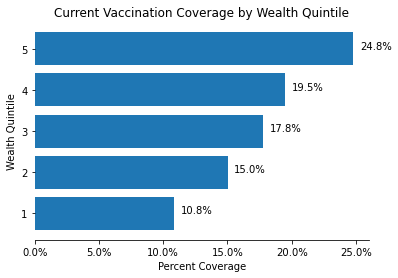

In [34]:
fig, ax = plt.subplots()
bars =ax.barh(range(1,6,1), [i*100 for i in vaccination_by_quintile], align='center')
plt.yticks(range(1,6))

plt.ylabel("Wealth Quintile")

plt.xlabel("Percent Coverage")


plt.title("Current Vaccination Coverage by Wealth Quintile")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=None, symbol='%', is_latex=False))


for i, v in enumerate([i*100 for i in vaccination_by_quintile]):
    ax.text(v+0.5, i+1 , '{:.1f}%'.format(v), color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('gamma100_Figures_5_14/Quintile_Current Vaccine Coverage by Wealth Quintile.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/Quintile_Current Vaccine Coverage by Wealth Quintile.png',facecolor='white',bbox_inches='tight')
plt.show()


In [35]:
compiled_df=reduce(lambda x,y: pd.merge(x,y, on='Name', how='outer'), [geo_df, last_10_prev_df,last_10_novax_prev_df,last_10_difference_df_prev,last_10_difference_df_abx,last_10_difference_df_cases,last_10_difference_df_deaths, total_vaccinated_by_state_df,state_pop_df])

In [38]:
from scipy.optimize import curve_fit
from numpy import sin,cos
from numpy import sqrt
from matplotlib import pyplot

# define the true objective function
def objective(x, a1, a, b, c):
    return a1*(x**3)+a*(x**2) + b*x + c
 

In [41]:
compiled_df['percent_vaccinated']=compiled_df['proportion_vaccinated']*100

C:\Users\alecm\AppData\Local\Temp\ipykernel_19684\2740604137.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.1f}%'.format(x) for x in cbar.get_ticks()])


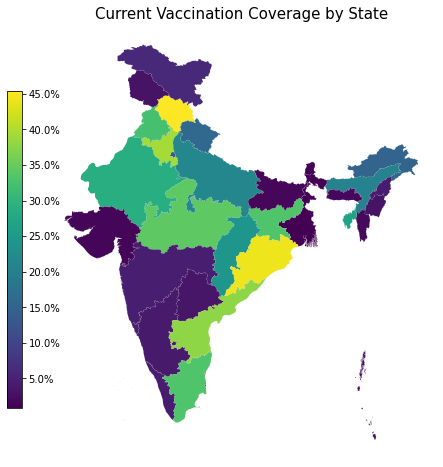

In [42]:
title = "\n".join(wrap("Current Vaccination Coverage by State", 50))
col = 'percent_vaccinated'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])



cbar = fig.colorbar(sm, cax=cbaxes)
cbar.ax.set_yticklabels(['{:.1f}%'.format(x) for x in cbar.get_ticks()])

# Add colorbar to figure
plt.savefig('gamma100_Figures_5_14/States_Vaccination Coverage by State.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/States_Vaccination Coverage by State.png',facecolor='white',bbox_inches='tight')

In [45]:
compiled_df['No vaccination prevalence above mean']=[i*100/np.mean(compiled_df['Prevalence without vaccination'].values) for i in compiled_df['Prevalence without vaccination'].values]
compiled_df['Vaccination prevalence above mean']=[i*100/np.mean(compiled_df['Current prevalence with vaccination'].values) for i in compiled_df['Current prevalence with vaccination'].values]

C:\Users\alecm\AppData\Local\Temp\ipykernel_19684\2237422617.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.1f}%'.format(x) for x in cbar.get_ticks()])


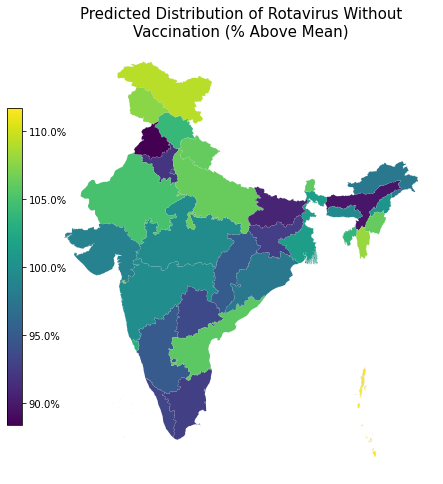

In [46]:
title = "\n".join(wrap("Predicted Distribution of Rotavirus Without Vaccination (% Above Mean)", 50))
col = 'No vaccination prevalence above mean'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])



cbar = fig.colorbar(sm, cax=cbaxes)
cbar.ax.set_yticklabels(['{:.1f}%'.format(x) for x in cbar.get_ticks()])

    
# Add colorbar to figure
plt.savefig('gamma100_Figures_5_14/States_Prevalence of Rotavirus % Above Mean (No Vax).svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/States_Prevalence of Rotavirus % Above Mean (No Vax).png',facecolor='white',bbox_inches='tight')

C:\Users\alecm\AppData\Local\Temp\ipykernel_19684\2551071816.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.3f}%'.format(x) for x in cbar.get_ticks()])


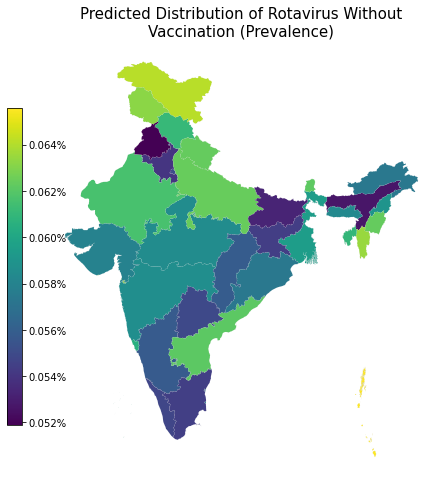

In [47]:
title = "\n".join(wrap("Predicted Distribution of Rotavirus Without Vaccination (Prevalence)", 50))
col = 'Prevalence without vaccination'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])



cbar = fig.colorbar(sm, cax=cbaxes)
cbar.ax.set_yticklabels(['{:.3f}%'.format(x) for x in cbar.get_ticks()])

    
# Add colorbar to figure
plt.savefig('gamma100_Figures_5_14/States_Prevalence of Rotavirus (No Vax).svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/States_Prevalence of Rotavirus (No Vax).png',facecolor='white',bbox_inches='tight')

C:\Users\alecm\AppData\Local\Temp\ipykernel_19684\3956077511.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.1f}%'.format(x) for x in cbar.get_ticks()])


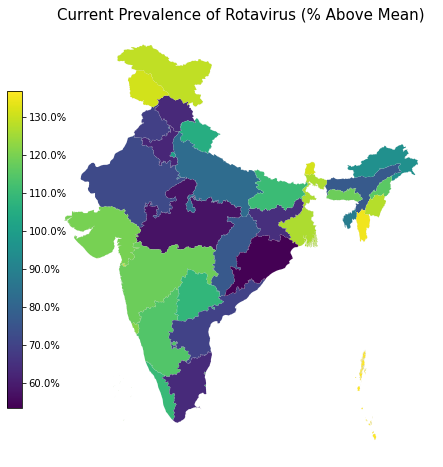

In [50]:
title = "\n".join(wrap("Current Prevalence of Rotavirus (% Above Mean)", 50))
col = 'Vaccination prevalence above mean'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})

# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])



cbar = fig.colorbar(sm, cax=cbaxes)
cbar.ax.set_yticklabels(['{:.1f}%'.format(x) for x in cbar.get_ticks()])

    
# Add colorbar to figure
plt.savefig('gamma100_Figures_5_14/States_Prevalence of Rotavirus % Above Mean (10-year incrementing to current).svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/States_Prevalence of Rotavirus % Above Mean (10-year incrementing to current).png',facecolor='white',bbox_inches='tight')

C:\Users\alecm\AppData\Local\Temp\ipykernel_19684\2713515425.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.3f}'.format(x) for x in cbar.get_ticks()])


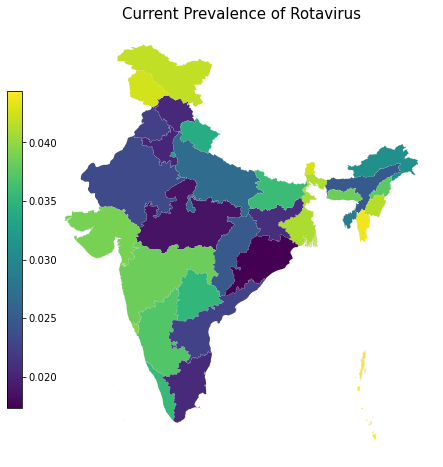

In [51]:
title = "\n".join(wrap("Current Prevalence of Rotavirus", 50))
col = 'Current prevalence with vaccination'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})

# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])



cbar = fig.colorbar(sm, cax=cbaxes)
cbar.ax.set_yticklabels(['{:.3f}'.format(x) for x in cbar.get_ticks()])

    
# Add colorbar to figure
plt.savefig('gamma100_Figures_5_14/States_Current Prevalence of Rotavirus.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/States_Current Prevalence of Rotavirus.png',facecolor='white',bbox_inches='tight')

C:\Users\alecm\AppData\Local\Temp\ipykernel_19684\2264517461.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.1f}%'.format(x) for x in cbar.get_ticks()])


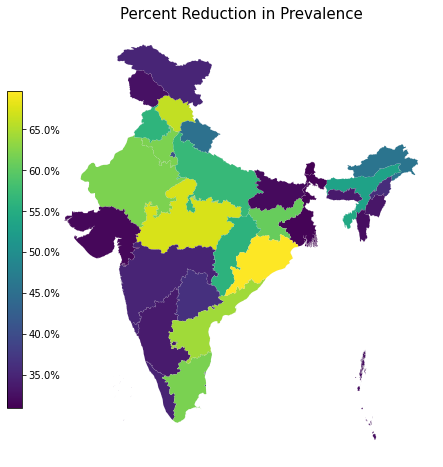

In [52]:
title = "\n".join(wrap("Percent Reduction in Prevalence", 50))
col = 'Difference in prevalence'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar

# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])



cbar = fig.colorbar(sm, cax=cbaxes)
cbar.ax.set_yticklabels(['{:.1f}%'.format(x) for x in cbar.get_ticks()])

    
# Add colorbar to figure
plt.savefig('gamma100_Figures_5_14/States_Percent Reduction in Prevalence.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/States_Percent Reduction in Prevalence.png',facecolor='white',bbox_inches='tight')

C:\Users\alecm\AppData\Local\Temp\ipykernel_19684\940529906.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.1f}'.format(x) for x in cbar.get_ticks()])


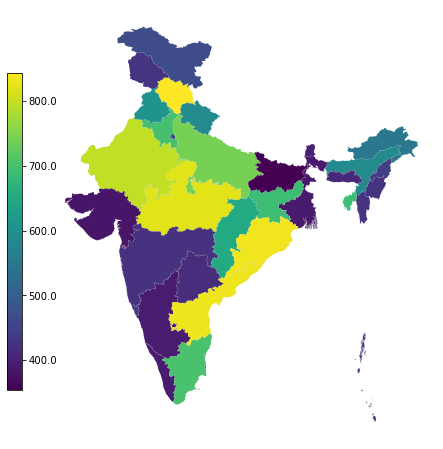

In [53]:
#title = "\n".join(wrap("Reduced Cases per Child per Year", 50))
col = 'Difference in cases per 1000 children per year'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

#ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar

# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])



cbar = fig.colorbar(sm, cax=cbaxes)
cbar.ax.set_yticklabels(['{:.1f}'.format(x) for x in cbar.get_ticks()])

    
# Add colorbar to figure
plt.savefig('gamma100_Figures_5_14/States_Reduced Cases per 1000 Children per Year.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/States_Reduced Cases per 1000 Children per Year.png',facecolor='white',bbox_inches='tight')

C:\Users\alecm\AppData\Local\Temp\ipykernel_19684\2732280651.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.1f}'.format(x) for x in cbar.get_ticks()])


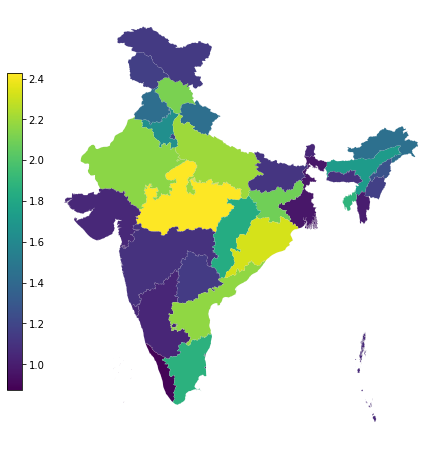

In [54]:
#title = "\n".join(wrap("Reduced Deaths per 10,000 Children per Year", 50))
col = 'Difference in deaths per 1000 children per year'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

#ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar

# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)

# Add colorbar to figure
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])



cbar = fig.colorbar(sm, cax=cbaxes)
cbar.ax.set_yticklabels(['{:.1f}'.format(x) for x in cbar.get_ticks()])

    
# Add colorbar to figure
plt.savefig('gamma100_Figures_5_14/States_Decrease in Deaths per 1000 Children per Year.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/States_Decrease in Deaths per 1000 Children per Year.png',facecolor='white',bbox_inches='tight')

C:\Users\alecm\AppData\Local\Temp\ipykernel_19684\3625156702.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.1f}'.format(x) for x in cbar.get_ticks()])


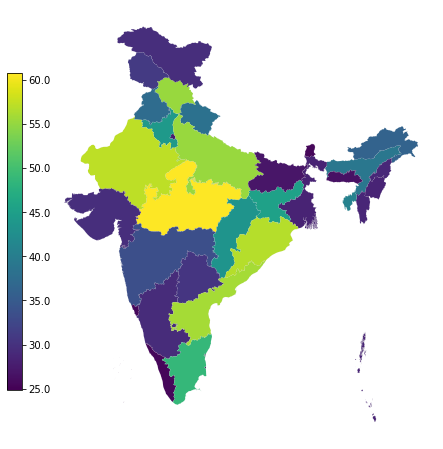

In [55]:
#title = "\n".join(wrap("Reduced Antibiotic Courses per Child per Year", 50))
col = 'Difference in antibiotics per 1000 children per year'
cmap='viridis'

fig, ax = plt.subplots(1, figsize=(20, 8))

ax.axis('off')
compiled_df.plot(column=col, ax=ax,edgecolor='0.8', linewidth=0.05, cmap=cmap,missing_kwds={'color': 'lightgrey'})

#ax.set_title(title, fontdict={'fontsize': '15', 'fontweight': '3'})


# Create colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=compiled_df[col].min(), vmax=compiled_df[col].max()), cmap=cmap)
cbaxes = fig.add_axes([0.35, 0.215, 0.01, 0.55])

cbar = fig.colorbar(sm, cax=cbaxes)

cbar.ax.set_yticklabels(['{:.1f}'.format(x) for x in cbar.get_ticks()])

    
# Add colorbar to figure
plt.savefig('gamma100_Figures_5_14/States_Difference in Antibiotic Misuse per 1000 Children per Year.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/States_Difference in Antibiotic Misuse per 1000 Children per Year.png',facecolor='white',bbox_inches='tight')

In [56]:
difference_median_vaccinated_quintile_prevalence=dict()

quintile_prev_vacc=dict()

difference_median_vaccinated_quintile_prevalence_CIs=dict()
for quintile in range(5):
    prevalence_quintile_vacc=[]
    for i in range(len(current_vaccination_curves)):
        
        pop_by_quintile=np.array(current_vaccination_curves[i][11][quintile])-np.array(current_vaccination_curves[i][16][quintile])-np.array(current_vaccination_curves[i][28][quintile])            #alive per state = total alive * state pop/ total pop
        pop_by_quintile=np.mean(pop_by_quintile[len(pop_by_quintile)-365*2:len(pop_by_quintile)])
            
        prevalence_quintile_vacc+=[current_vaccination_curves[i][21][quintile+1]/pop_by_quintile/(current_vaccination_curves[i][20])*current_vaccination_curves[i][7]]
    
    
    prevalence_quintile_no_vacc=[]
    quintile_prev_vacc[quintile]=prevalence_quintile_no_vacc
    for i in range(len(no_vaccination_curves)):
        pop_by_quintile=np.array(no_vaccination_curves[i][11][quintile])-np.array(no_vaccination_curves[i][16][quintile])-np.array(no_vaccination_curves[i][27][quintile])            #alive per state = total alive * state pop/ total pop
        pop_by_quintile=np.mean(pop_by_quintile[len(pop_by_quintile)-365*2:len(pop_by_quintile)])
            
        prevalence_quintile_no_vacc+=[no_vaccination_curves[i][21][quintile+1]/pop_by_quintile/(no_vaccination_curves[i][20])*no_vaccination_curves[i][7]]     
    
    
    

    lower, upper, median = percentile_confidence_interval(np.array(prevalence_quintile_no_vacc)-np.array(prevalence_quintile_vacc))

    if quintile in [0,4]:
        print(quintile+1,':',(lower/np.median(prevalence_quintile_no_vacc),upper/np.median(prevalence_quintile_no_vacc)),median/np.median(prevalence_quintile_no_vacc))
    
    difference_median_vaccinated_quintile_prevalence[quintile+1]=100*median/np.median(prevalence_quintile_no_vacc)
    
    difference_median_vaccinated_quintile_prevalence_CIs[quintile+1]=(100*lower/np.median(prevalence_quintile_no_vacc),100*upper/np.median(prevalence_quintile_no_vacc))

1 : (0.41763822753387714, 0.48776778013978495) 0.45802880069354435
5 : (0.4278089992404446, 0.5063549934722329) 0.46636155808397955


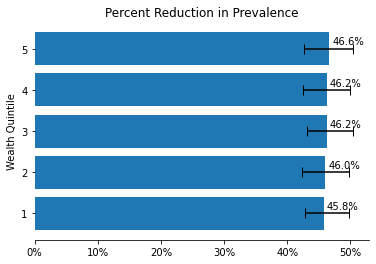

In [204]:
fig, ax = plt.subplots()
bars =ax.barh(range(len(difference_median_vaccinated_quintile_prevalence)), list(difference_median_vaccinated_quintile_prevalence.values()), align='center',
             xerr=[np.array([i[0]-m for i,m in zip(list(difference_median_vaccinated_quintile_prevalence_CIs.values()),list(difference_median_vaccinated_quintile_prevalence.values()))]),
np.array([m-i[1] for i,m in zip(list(difference_median_vaccinated_quintile_prevalence_CIs.values()),list(difference_median_vaccinated_quintile_prevalence.values()))])],capsize=5)
plt.yticks(range(len(difference_median_vaccinated_quintile_prevalence)), list(difference_median_vaccinated_quintile_prevalence.keys()))

plt.ylabel("Wealth Quintile")

plt.title("Percent Reduction in Prevalence")

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=None, symbol='%', is_latex=False))



for i, v in enumerate(list(difference_median_vaccinated_quintile_prevalence.values())):
    ax.text(v+0.5, i+0.1 , '{:.1f}%'.format(v), color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('gamma100_Figures_5_14/Quintile_Reduced Prevalence Due to Vaccination by Wealth Quintile.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/Quintile_Reduced Prevalence Due to Vaccination by Wealth Quintile.png',facecolor='white',bbox_inches='tight')

plt.show()


In [60]:
difference_median_vaccinated_quintile_incidence=dict()

difference_median_vaccinated_quintile_incidence_CIs=dict()

quintile_incidence_vacc=dict()

for quintile in range(5):
    incidence_quintile_vacc=[]
    duration_steady_state=np.median([i[20] for i in current_vaccination_curves])
    for i in range(len(current_vaccination_curves)):
        pop_by_quintile=np.array(current_vaccination_curves[i][11][quintile])-np.array(current_vaccination_curves[i][16][quintile])-np.array(current_vaccination_curves[i][28][quintile])            #alive per state = total alive * state pop/ total pop
        pop_by_quintile=np.mean(pop_by_quintile[len(pop_by_quintile)-365*2:len(pop_by_quintile)])
        
        incidence_quintile_vacc+=[1000*current_vaccination_curves[i][21][quintile+1]/pop_by_quintile/2]    
        quintile_incidence_vacc[quintile]=incidence_quintile_vacc

        
    incidence_quintile_no_vacc=[]
    duration_steady_state=np.median([i[20] for i in no_vaccination_curves])
    for i in range(len(no_vaccination_curves)):
        pop_by_quintile=np.array(no_vaccination_curves[i][11][quintile])-np.array(no_vaccination_curves[i][16][quintile])-np.array(no_vaccination_curves[i][27][quintile])            #alive per state = total alive * state pop/ total pop
        pop_by_quintile=np.mean(pop_by_quintile[len(pop_by_quintile)-365*2:len(pop_by_quintile)])
            
        incidence_quintile_no_vacc+=[1000*no_vaccination_curves[i][21][quintile+1]/pop_by_quintile/2]     
    
    lower, upper, median = percentile_confidence_interval(np.array(incidence_quintile_no_vacc)-np.array(incidence_quintile_vacc))

    if quintile in [0,4]:
        print(quintile+1,':',(lower,upper),median)
    
    difference_median_vaccinated_quintile_incidence[quintile+1]=median
    
    difference_median_vaccinated_quintile_incidence_CIs[quintile+1]=(lower,upper)

1 : (514.9056103397727, 601.3871423469202) 563.6383149393203
5 : (528.1944485723174, 625.8023776700845) 575.6314325245448


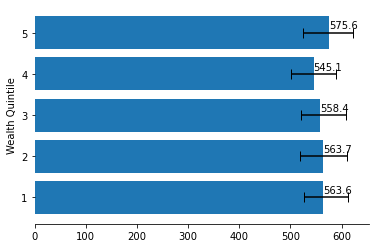

In [203]:
fig, ax = plt.subplots()
bars =ax.barh(range(len(difference_median_vaccinated_quintile_incidence)), list(difference_median_vaccinated_quintile_incidence.values()), align='center',
             xerr=[np.array([i[0]-m for i,m in zip(list(difference_median_vaccinated_quintile_incidence_CIs.values()),list(difference_median_vaccinated_quintile_incidence.values()))]),
np.array([m-i[1] for i,m in zip(list(difference_median_vaccinated_quintile_incidence_CIs.values()),list(difference_median_vaccinated_quintile_incidence.values()))])],capsize=5)
plt.yticks(range(len(difference_median_vaccinated_quintile_incidence)), list(difference_median_vaccinated_quintile_incidence.keys()))

plt.ylabel("Wealth Quintile")

#plt.title("Reduced Cases per Child per Year")

#ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=None, symbol='%', is_latex=False))



for i, v in enumerate(list(difference_median_vaccinated_quintile_incidence.values())):
    ax.text(v+0.005, i+0.1 , '{:.1f}'.format(v), color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('gamma100_Figures_5_14/Quintile_Reduced Cases per 1000 Children per Year.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/Quintile_Reduced Cases per 1000 Children per Year.png',facecolor='white',bbox_inches='tight')

plt.show()


In [64]:
difference_median_vaccinated_quintile_abx=dict()

difference_median_vaccinated_quintile_abx_CIs=dict()

quintile_abx_vacc=dict()

for quintile in range(5):
    abx_quintile_vacc=[]
    duration_steady_state=np.median([i[20] for i in current_vaccination_curves])
    for i in range(len(current_vaccination_curves)):
        pop_by_quintile=np.array(current_vaccination_curves[i][11][quintile])-np.array(current_vaccination_curves[i][16][quintile])-np.array(current_vaccination_curves[i][28][quintile])            #alive per state = total alive * state pop/ total pop
        pop_by_quintile=np.mean(pop_by_quintile[len(pop_by_quintile)-365*2:len(pop_by_quintile)])
        
        
        abx_quintile_vacc+=[1000*current_vaccination_curves[i][22][quintile+1]/pop_by_quintile/2]    
    
        quintile_abx_vacc[quintile]=abx_quintile_vacc

        
    abx_quintile_no_vacc=[]
    duration_steady_state=np.median([i[20] for i in no_vaccination_curves])
    for i in range(len(no_vaccination_curves)):
        pop_by_quintile=np.array(no_vaccination_curves[i][11][quintile])-np.array(no_vaccination_curves[i][16][quintile])-np.array(no_vaccination_curves[i][27][quintile])            #alive per state = total alive * state pop/ total pop
        pop_by_quintile=np.mean(pop_by_quintile[len(pop_by_quintile)-365*2:len(pop_by_quintile)])
            
        abx_quintile_no_vacc+=[1000*no_vaccination_curves[i][22][quintile+1]/pop_by_quintile/2]     
    
    
    lower, upper, median = percentile_confidence_interval(np.array(abx_quintile_no_vacc)-np.array(abx_quintile_vacc))

    if quintile in [0,4]:
        print(quintile+1,':',(lower,upper),median)
    
    difference_median_vaccinated_quintile_abx[quintile+1]=median
    
    difference_median_vaccinated_quintile_abx_CIs[quintile+1]=(lower,upper)

1 : (29.493570629955478, 38.806544666392234) 34.5847867119988
5 : (22.91390790836338, 31.743158084450258) 27.096189315700027


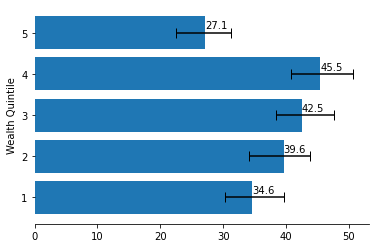

In [202]:
fig, ax = plt.subplots()
bars =ax.barh(range(len(difference_median_vaccinated_quintile_abx)), list(difference_median_vaccinated_quintile_abx.values()), align='center',
             xerr=[np.array([i[0]-m for i,m in zip(list(difference_median_vaccinated_quintile_abx_CIs.values()),list(difference_median_vaccinated_quintile_abx.values()))]),
np.array([m-i[1] for i,m in zip(list(difference_median_vaccinated_quintile_abx_CIs.values()),list(difference_median_vaccinated_quintile_abx.values()))])],capsize=5)
plt.yticks(range(len(difference_median_vaccinated_quintile_abx)), list(difference_median_vaccinated_quintile_abx.keys()))

plt.ylabel("Wealth Quintile")

#plt.title("Reduced Antibiotic Courses per Child per Year")

#ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=None, symbol='%', is_latex=False))



for i, v in enumerate(list(difference_median_vaccinated_quintile_abx.values())):
    ax.text(v+0.00025, i+0.1 , '{:.1f}'.format(v), color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('gamma100_Figures_5_14/Quintile_Reduced Antibiotic Courses per 1000 Children per Year.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/Quintile_Reduced Antibiotic Courses per 1000 Children per Year.png',facecolor='white',bbox_inches='tight')

plt.show()


In [66]:
difference_median_vaccinated_quintile_deaths=dict()

difference_median_vaccinated_quintile_deaths_CIs=dict()

quintile_deaths_vacc=dict()

for quintile in range(5):
    deaths_quintile_vacc=[]
    duration_steady_state=np.median([i[20] for i in current_vaccination_curves])
    for i in range(len(current_vaccination_curves)):
        pop_by_quintile=np.array(current_vaccination_curves[i][11][quintile])-np.array(current_vaccination_curves[i][16][quintile])-np.array(current_vaccination_curves[i][28][quintile])            #alive per state = total alive * state pop/ total pop
        pop_by_quintile=np.mean(pop_by_quintile[len(pop_by_quintile)-365*2:len(pop_by_quintile)])
            
        deaths_quintile_vacc+=[1000*current_vaccination_curves[i][26][quintile+1]/pop_by_quintile/2]    
    
    quintile_deaths_vacc[quintile]=deaths_quintile_vacc

        
    deaths_quintile_no_vacc=[]
    duration_steady_state=np.median([i[20] for i in no_vaccination_curves])
    for i in range(len(no_vaccination_curves)):
        pop_by_quintile=np.array(no_vaccination_curves[i][11][quintile])-np.array(no_vaccination_curves[i][16][quintile])-np.array(no_vaccination_curves[i][27][quintile])            #alive per state = total alive * state pop/ total pop
        pop_by_quintile=np.mean(pop_by_quintile[len(pop_by_quintile)-365*2:len(pop_by_quintile)])
            
        deaths_quintile_no_vacc+=[1000*no_vaccination_curves[i][25][quintile+1]/pop_by_quintile/2]     
        
    lower, upper, median = percentile_confidence_interval(np.array(deaths_quintile_no_vacc)-np.array(deaths_quintile_vacc))

    if quintile in [0,4]:
        print(quintile+1,':',(lower,upper),median)
    
    difference_median_vaccinated_quintile_deaths[quintile+1]=median
    
    difference_median_vaccinated_quintile_deaths_CIs[quintile+1]=(lower,upper)

1 : (1.6719405975316695, 2.5094020347632693) 2.144545316309384
5 : (0.39676336121725425, 0.8665402564102574) 0.680506796602427


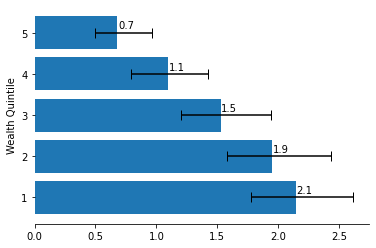

In [201]:
fig, ax = plt.subplots()
bars =ax.barh(range(len(difference_median_vaccinated_quintile_deaths)), list(difference_median_vaccinated_quintile_deaths.values()), align='center',
             xerr=[np.array([i[0]-m for i,m in zip(list(difference_median_vaccinated_quintile_deaths_CIs.values()),list(difference_median_vaccinated_quintile_deaths.values()))]),
np.array([m-i[1] for i,m in zip(list(difference_median_vaccinated_quintile_deaths_CIs.values()),list(difference_median_vaccinated_quintile_deaths.values()))])],capsize=5)
plt.yticks(range(len(difference_median_vaccinated_quintile_deaths)), list(difference_median_vaccinated_quintile_deaths.keys()))



asymmetric_error = [lower_error, upper_error]

ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')


plt.ylabel("Wealth Quintile")

#plt.title("Reduced Deaths per 10,000 Children per Year")

#ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=None, symbol='%', is_latex=False))



for i, v in enumerate(list(difference_median_vaccinated_quintile_deaths.values())):
    ax.text(v+0.005, i+0.1 , '{:.1f}'.format(v), color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('gamma100_Figures_5_14/Quintile_Reduced Deaths per 10,000 Children per Year.svg',facecolor='white',bbox_inches='tight')
plt.savefig('gamma100_Figures_5_14/Quintile_Reduced Deaths per 10,000 Children per Year.png',facecolor='white',bbox_inches='tight')

plt.show()


In [68]:
total_prev_vacc=sum([np.median(quintile_prev_vacc[0]),np.median(quintile_prev_vacc[1]),np.median(quintile_prev_vacc[2]),np.median(quintile_prev_vacc[3]),np.median(quintile_prev_vacc[4])])

lower, upper, median = percentile_confidence_interval(np.array(quintile_prev_vacc[4])-np.array(quintile_prev_vacc[0]))

print("Difference in medians q1 and q5 prevalence:",lower, upper, median)

Difference in medians q1 and q5 prevalence: -0.0007145099897592473 0.000992175974325977 0.0002135004382412091


### By quintile to csv

In [69]:
quintiles=[]
reduced_prev=[]
reduced_cases=[]
reduced_abx=[]
reduced_deaths=[]
for quintile in difference_median_vaccinated_quintile_prevalence.keys():
    quintiles+=[quintile]
    reduced_cases+=[str(round(difference_median_vaccinated_quintile_incidence[quintile],1)) + ' '+ str(tuple([round(i,1) for i in difference_median_vaccinated_quintile_incidence_CIs[quintile]]))]
                   
    reduced_prev+=[str(round(difference_median_vaccinated_quintile_prevalence[quintile],1)) + ' '+ str(tuple([round(i,1) for i in difference_median_vaccinated_quintile_prevalence_CIs[quintile]]))]
    reduced_abx+=[str(round(difference_median_vaccinated_quintile_abx[quintile],1)) + ' '+ str(tuple([round(i,1) for i in difference_median_vaccinated_quintile_abx_CIs[quintile]]))]
    reduced_deaths+=[str(round(difference_median_vaccinated_quintile_deaths[quintile],1)) + ' '+ str(tuple([round(i,1) for i in difference_median_vaccinated_quintile_deaths_CIs[quintile]]))]

In [71]:
reduced_burden_by_quintile=pd.DataFrame(data=zip(quintiles,reduced_prev,reduced_cases,reduced_abx, reduced_deaths),columns=['State','Reduced Prevalence (% Reduction)','Reduced Cases per 1000 Children per Year','Reduced Antibiotic Courses per 1000 Children per Year','Reduced Deaths per 1000 Children per Year'])

In [73]:
reduced_burden_by_quintile.to_csv('reduced_rota_burden_current_vaccination_by_quintile.csv',index=False)

## Below: Remember, quintile 5 has the least antibiotic use

In [161]:
lower, upper, median = percentile_confidence_interval(np.array(quintile_abx_vacc[3])-np.array(quintile_abx_vacc[4]))


median_abx_4=np.median(quintile_abx_vacc[3])
print("Percentage less abx use in q5 than q4:",(lower/median_abx_4)*100, (upper/median_abx_4)*100, (median/median_abx_4)*100)
print("Less abx use in q5 than q4:",lower, upper, median)

Percentage less abx use in q5 than q4: 13.438469505632572 19.828147513229172 16.726008488715955
Less abx use in q5 than q4: 9.70402174965747 14.318057174825233 12.077978827233636


In [75]:
lower, upper, median = percentile_confidence_interval(np.array(quintile_incidence_vacc[0])-np.array(quintile_incidence_vacc[4]))

median_incidence_5=np.median(quintile_incidence_vacc[4])

print("Less less incidence in medians q1 than q5:",lower, upper, median)
print("Percentage less incidence in medians q1 than q5:",(lower/median_incidence_5)*100, (upper/median_incidence_5)*100, (median/median_incidence_5)*100)

Less less incidence in medians q1 than q5: 0.56530632064636 21.613252126315956 11.626149662222417
Percentage less incidence in medians q1 than q5: 0.08541980414657467 3.265839592045494 1.756752738922695


In [76]:
lower, upper, median = percentile_confidence_interval(np.array(quintile_deaths_vacc[0])-np.array(quintile_deaths_vacc[4]))

median_deaths_5=np.median(quintile_deaths_vacc[4])

print("Less deaths in medians q1 than q5:",lower, upper, median)
print("Percentage less deaths in medians q1 than q5:",(lower/median_deaths_5)*100, (upper/median_deaths_5)*100, (median/median_deaths_5)*100)


Less deaths in medians q1 than q5: 1.3016699736000528 1.928081916401882 1.61425058212197
Percentage less deaths in medians q1 than q5: 206.13007045634723 305.3275172156993 255.62976251708454


In [83]:
nationwide_current_vacc_prevalence=[]

for i in range(len(current_vaccination_curves)):
    try:
        total_alive_current=sum([np.array(current_vaccination_curves[i][11][i])-np.array(current_vaccination_curves[i][16][i])-np.array(current_vaccination_curves[i][28][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
        total_alive_current=np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])
        nationwide_current_vacc_prevalence+=[sum([current_vaccination_curves[i][18][state] for state in statewise_current.keys()])/total_alive_current/(current_vaccination_curves[i][20])*current_vaccination_curves[i][7]]

    except:
        pass
nationwide_no_vacc_prevalence=[]
for i in range(len(no_vaccination_curves)):
    try:
        total_alive_current=sum([np.array(no_vaccination_curves[i][11][i])-np.array(no_vaccination_curves[i][16][i])-np.array(no_vaccination_curves[i][27][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
        total_alive_current=np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])
        nationwide_no_vacc_prevalence+=[sum([no_vaccination_curves[i][18][state] for state in statewise_current.keys()])/total_alive_current/(no_vaccination_curves[i][20])*no_vaccination_curves[i][7]]
    except:
        pass

In [88]:
nationwide_current_vacc_abx=[]

for i in range(len(current_vaccination_curves)):
    try:
        total_alive_current=sum([np.array(current_vaccination_curves[i][11][i])-np.array(current_vaccination_curves[i][16][i])-np.array(current_vaccination_curves[i][28][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
        total_alive_current=np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])
        nationwide_current_vacc_abx+=[1000*sum([current_vaccination_curves[i][19][state] for state in statewise_current.keys()])/total_alive_current/2]

    except:
        pass
print(total_alive_current)


nationwide_no_vacc_abx=[]
for i in range(len(no_vaccination_curves)):
    try:
        total_alive_current=sum([np.array(no_vaccination_curves[i][11][i])-np.array(no_vaccination_curves[i][16][i])-np.array(no_vaccination_curves[i][27][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
        total_alive_current=np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])
        nationwide_no_vacc_abx+=[1000*sum([no_vaccination_curves[i][19][state] for state in statewise_current.keys()])/total_alive_current/2]
    except:
        pass
print(total_alive_current)


311008.501369863
311151.4712328767


In [89]:
nationwide_current_vacc_incidence=[]

for i in range(len(current_vaccination_curves)):
    try:
        total_alive_current=sum([np.array(current_vaccination_curves[i][11][i])-np.array(current_vaccination_curves[i][16][i])-np.array(current_vaccination_curves[i][28][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
        total_alive_current=np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])
        nationwide_current_vacc_incidence+=[1000*sum([current_vaccination_curves[i][18][state] for state in statewise_current.keys()])/total_alive_current/2]

    except:
        pass


nationwide_no_vacc_incidence=[]
for i in range(len(no_vaccination_curves)):
    try:
        total_alive_current=sum([np.array(no_vaccination_curves[i][11][i])-np.array(no_vaccination_curves[i][16][i])-np.array(no_vaccination_curves[i][27][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
        total_alive_current=np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])
        nationwide_no_vacc_incidence+=[1000*sum([no_vaccination_curves[i][18][state] for state in statewise_current.keys()])/total_alive_current/2]
    except:
        pass

In [90]:
nationwide_current_vacc_deaths=[]

for i in range(len(current_vaccination_curves)):
    try:
        total_alive_current=sum([np.array(current_vaccination_curves[i][11][i])-np.array(current_vaccination_curves[i][16][i])-np.array(current_vaccination_curves[i][28][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
        total_alive_current=np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])
        
        nationwide_current_vacc_deaths+=[1000*sum([current_vaccination_curves[i][27][state] for state in statewise_current.keys()])/total_alive_current/2]

    except:
        pass


nationwide_no_vacc_deaths=[]
for i in range(len(no_vaccination_curves)):
    try:
        total_alive_current=sum([np.array(no_vaccination_curves[i][11][i])-np.array(no_vaccination_curves[i][16][i])-np.array(no_vaccination_curves[i][27][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
        total_alive_current=np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])
        nationwide_no_vacc_deaths+=[1000*sum([no_vaccination_curves[i][26][state] for state in statewise_current.keys()])/total_alive_current/2]
    except:
        pass

In [91]:
pop_by_quintile=[]

for quintile in range(5):
    pop_by_quintile+=[current_vaccination_curves[i][11][quintile][len(current_vaccination_curves[i][11][quintile])-1]-
    current_vaccination_curves[i][16][quintile][len(current_vaccination_curves[i][16][quintile])-1]]

# 95% CI for proportional decrease in disease prevalence

In [92]:
def median_bootstrap_stat(array, function):
    stats=[]
    for i in range(10000):
        stats+=[function(choices(array,k=len(array)))]
    return(np.median(stats))

In [93]:
lower, upper, median = percentile_confidence_interval(np.array(nationwide_no_vacc_prevalence)-np.array(nationwide_current_vacc_prevalence))

median_stat=np.median(nationwide_no_vacc_prevalence)

print("MEDIAN:",(lower,upper),median)
print("% MEDIAN:",(lower/median_stat,upper/median_stat),median/median_stat)

MEDIAN: (0.02474191477337744, 0.029149048037764993) 0.02690365658928215
% MEDIAN: (0.4238403813561748, 0.4993366014577575) 0.46087201306450637


# 95% CI for proportional decrease in abx use due to disease

In [94]:
lower, upper, median = percentile_confidence_interval(np.array(nationwide_no_vacc_abx)-np.array(nationwide_current_vacc_abx))

median_stat=np.median(nationwide_no_vacc_abx)

print("MEDIAN:",(lower,upper),median)
print("% MEDIAN:",(lower/median_stat,upper/median_stat),median/median_stat)

MEDIAN: (33.81898376930518, 42.36577755921574) 38.201953795104984
% MEDIAN: (0.3272277557465625, 0.4099253367791268) 0.369636760547844


# 95% CI for proportional decrease in incidence (per child per year) due to disease

In [95]:
lower, upper, median = percentile_confidence_interval(np.array(nationwide_no_vacc_incidence)-np.array(nationwide_current_vacc_incidence))

median_stat=np.median(nationwide_no_vacc_incidence)

print("MEDIAN:",(lower,upper),median)
print("% MEDIAN:",(lower/median_stat,upper/median_stat),median/median_stat)

MEDIAN: (515.4364080340944, 607.8748465883739) 559.9514979818588
% MEDIAN: (0.42333702223749686, 0.4992583438746444) 0.45989805155049485


# 95% CI for proportional decrease in deaths (per child per year) due to disease

In [96]:
lower, upper, median = percentile_confidence_interval(np.array(nationwide_no_vacc_deaths)-np.array(nationwide_current_vacc_deaths))

median_stat=np.median(nationwide_no_vacc_deaths)

print("MEDIAN:",(lower,upper),median)
print("% MEDIAN:",(lower/median_stat,upper/median_stat),median/median_stat)

MEDIAN: (1.267606528620989, 1.6810129739599236) 1.4857033093760261
% MEDIAN: (0.415723463846978, 0.5513039894694953) 0.48725035101755393


# Curent abx use under-5 due to Rota relative to all of india (using average data per day across all ages: https://pubmed.ncbi.nlm.nih.gov/36320447/ data)

In [97]:
#For 2011-2019: abx use median was 10.7 DDD per day per 1000
DDD=10.7*(1.28678329596971*12063641.4898956+ 1.11824112316813*(12203339.58+ 12400370.7700615+12592280.55161+12764026.1906926))/(12063641.4898956+12203339.58+ 12400370.7700615+12592280.55161+12764026.1906926)
print('DDD per 1,0000 children under 5 years old per day:', 10.7*(1.28678329596971*12063641.4898956+ 1.11824112316813*(12203339.58+ 12400370.7700615+12592280.55161+12764026.1906926))/(12063641.4898956+12203339.58+ 12400370.7700615+12592280.55161+12764026.1906926))

DDD per 1,0000 children under 5 years old per day: 12.315942720831673


# CURRENT ABX USE Due to Rota  RELATIVE TO ALL OF INDIA (AVERAGE PER DAY)

### To report current use

In [102]:
taking_abx_vacc_rel_total=[]
for i in range(1,len(no_vaccination_curves)):
    total_alive_current=sum([np.array(current_vaccination_curves[i][11][i])-np.array(current_vaccination_curves[i][16][i])-np.array(current_vaccination_curves[i][28][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
    total_alive_current=np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])
    

    taking_abx_vacc_rel_total+=[sum([current_vaccination_curves[i][19][state] for state in statewise_current.keys()])/total_alive_current/(365*2)*5* 1000/DDD]
    


In [103]:
taking_abx_no_vacc_rel_total=[]
for i in range(1,len(no_vaccination_curves)):
    total_alive_current=sum([np.array(no_vaccination_curves[i][11][i])-np.array(no_vaccination_curves[i][16][i])-np.array(no_vaccination_curves[i][27][i]) for i in range(5)])            #alive per state = total alive * state pop/ total pop
    total_alive_current=np.mean(total_alive_current[len(total_alive_current)-365*2:len(total_alive_current)])
    

    taking_abx_no_vacc_rel_total+=[sum([no_vaccination_curves[i][19][state] for state in statewise_current.keys()])/total_alive_current/(365*2)*5* 1000/DDD]
    


In [105]:
from scipy.stats import bootstrap

lower, upper, median_stat_abx_vacc = percentile_confidence_interval(np.array(taking_abx_vacc_rel_total))


print("MEDIAN:",(lower,upper),median_stat_abx_vacc)

MEDIAN: (0.06950439489413578, 0.07692732976317179) 0.07268169319028182


# No vaccine abx use due to Rotavirus relatie to all of india (average per day)

In [108]:
from scipy.stats import bootstrap

lower, upper, median_stat_abx_no_vacc = percentile_confidence_interval(np.array(taking_abx_no_vacc_rel_total))



scale_factor = 1/(1+(median_stat_abx_no_vacc-median_stat_abx_vacc)) #account for increased total abx use in India if this increased
                                                                    #rotavirus-associated abx use was accounted for


print("MEDIAN:",(lower*scale_factor,upper*scale_factor),median_stat_abx_no_vacc*scale_factor)

MEDIAN: (0.10842900832624677, 0.11307773944953317) 0.11030297393601746


# How much to increase vaccination coverage by state to reach less than 1/100,000 prevalence of rotavirus:

In [131]:
with open("gamma_latest_3_22_current_data/universal_vaccination_curves_returned.pkl",'rb') as handle:
    future_vaccination_curves=pickle.load(handle)

In [132]:
from scipy.stats import bootstrap
increase_vaccination_amounts=[]

for i in range(1,len(future_vaccination_curves)):
    increase_vaccination_amounts+=[future_vaccination_curves[i][25]]
    
lower, upper, median = percentile_confidence_interval(np.array(increase_vaccination_amounts))

print("MEDIAN:",(lower,upper),median)

MEDIAN: (0.27409975855236723, 0.4876054552927171) 0.41134150610005527


In [111]:
future_vaccination_curves[i][25]

0.42531252034637673

In [133]:
current_cov=sum(compiled_df['proportion_vaccinated']*compiled_df['Population'])/sum(compiled_df['Population'])
print("Median Increase by:",(lower-current_cov,upper-current_cov),median-current_cov)

Median Increase by: (0.09573547676998376, 0.30924117351033364) 0.2329772243176718


In [115]:
compiled_df_stats_only=compiled_df.drop(columns=['geometry'])

In [123]:
from scipy.stats import bootstrap
initial_vaccination_amounts=[]

for i in range(1,len(future_vaccination_curves)):
    initial_vaccination_amounts+=[future_vaccination_curves[i][27]]
    
lower, upper, median = percentile_confidence_interval(np.array(initial_vaccination_amounts))


print("MEDIAN:",(lower,upper),median)

MEDIAN: (0.009940803333155853, 0.011198868662627865) 0.010643192957887366


## Distribution of wealth quintile in infected 

In [124]:
difference_median_vaccinated_quintile_composition=dict()

difference_median_vaccinated_quintile_composition_CIs=dict()

quintile_composition_vacc=dict()

test=dict()

for quintile in range(5):
    composition_quintile_vacc=[]
    duration_steady_state=np.median([i[20] for i in current_vaccination_curves])
    for i in range(len(current_vaccination_curves)):
        
        total_infected=sum([np.mean(current_vaccination_curves[i][13][q][len(current_vaccination_curves[i][13][q])-365*2:len(current_vaccination_curves[i][13][q])])for q in range(5)])
        infected_quintile=np.mean(current_vaccination_curves[i][13][quintile][len(current_vaccination_curves[i][13][quintile])-365*2:len(current_vaccination_curves[i][13][quintile])])
            
        composition_quintile_vacc+=[infected_quintile/total_infected]    
    
    quintile_composition_vacc[quintile]=composition_quintile_vacc

        
    composition_quintile_no_vacc=[]
    duration_steady_state=np.median([i[20] for i in no_vaccination_curves])
    for i in range(len(no_vaccination_curves)):
        total_infected=sum([np.mean(no_vaccination_curves[i][13][q][len(no_vaccination_curves[i][13][q])-365*2:len(no_vaccination_curves[i][13][q])])for q in range(5)])
        infected_quintile=np.mean(no_vaccination_curves[i][13][quintile][len(no_vaccination_curves[i][13][quintile])-365*2:len(no_vaccination_curves[i][13][quintile])])
            
        composition_quintile_no_vacc+=[infected_quintile/total_infected]    
      
    median_no_vac = np.median(composition_quintile_no_vacc)
    
    lower, upper, median = percentile_confidence_interval(np.array(composition_quintile_no_vacc)-np.array(composition_quintile_vacc))
    
    if quintile in [0,1,2,3,4,5]:
        print(quintile+1,':',(100*(lower)/median_no_vac,100*(upper)/median_no_vac),100*(median)/median_no_vac)
    
    difference_median_vaccinated_quintile_composition[quintile+1]=100*(median)/median_no_vac
    
    difference_median_vaccinated_quintile_composition_CIs[quintile+1]=(100*(lower)/median_no_vac,100*(upper)/median_no_vac)

1 : (-4.343442864686655, -0.029104064146039617) -2.0664704500326745
2 : (-2.243842998605198, 1.9654686935738992) 0.14602786227728323
3 : (-1.1925726740679734, 2.9808582629681077) 0.888189578562393
4 : (-1.396387685285881, 2.917871740948324) 0.5603448877007696
5 : (-1.7010626504667892, 3.0504709767093434) 0.9557353598148172
